In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/theano/configdefaults.py:696: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn(
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Global seed set to 0


In [2]:
# /diskmnt/Datasets/Spatial_Transcriptomics/outputs/HT264P1/HT264P1-H2A2/outs

In [3]:
results_folder = '../data/spatial/cell2location/outputs/HT264P1-H2A2'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [4]:
adata_sp = sc.read_visium('/diskmnt/Datasets/Spatial_Transcriptomics/outputs/HT264P1/HT264P1-H2A2/outs')
adata_sp.obs['sample'] = list(adata_sp.uns['spatial'].keys())[0]
adata_sp.var_names_make_unique()
adata_sp
# # rename genes to ENSEMBL
# adata_vis.var['SYMBOL'] = adata_vis.var_names
# adata_vis.var_names = adata_vis.var['gene_ids']
# adata_vis.var_names.name = None

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4447 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata_sp.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC141272.1,ENSG00000277836,Gene Expression,GRCh38
AC023491.2,ENSG00000278633,Gene Expression,GRCh38
AC007325.1,ENSG00000276017,Gene Expression,GRCh38
AC007325.4,ENSG00000278817,Gene Expression,GRCh38


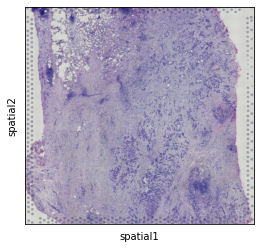

In [6]:
sc.pl.spatial(adata_sp)

In [7]:
# find mitochondria-encoded (MT) genes
adata_sp.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_sp.var.index.to_list()]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_sp.obsm['MT'] = adata_sp[:, adata_sp.var['MT_gene'].values].X.toarray()
adata_sp = adata_sp[:, ~adata_sp.var['MT_gene'].values]

In [8]:
adata_sc = sc.read_h5ad('../data/single_cell/checkpoints/non_eus_processed.h5ad')
adata_sc = adata_sc[[True if 'Exclude' not in ct else False
                    for ct in adata_sc.obs['cell_type_specific_final']]]
adata_sc

View of AnnData object with n_obs × n_vars = 104486 × 29227
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.0.75', 'seurat_clusters', 'sample_id', 'cell_type', 'pollock_cell_type', 'dataset', 'Bailey | ADEX | score', 'Bailey | Squamous-like | score', 'Bailey | Pancreatic-Progenitor | score', 'Bailey | Immunogenic | score', 'Collison | Exocrine-like | score', 'Collison | Quasi-Mesenchymal | score', 'Collison | Classical | score', 'Moffit | Basal | score', 'Moffit | Classical | score', 'subTME | deserted | score', 'subTME | reactive | score', 'raghaven | scBasal | score', 'raghaven | scClassical | score', 'raghaven | IC | score', 'raghaven | Pericyte-like | score', 'raghaven | Fibroblast-like | score', 'raghaven | Inflammatory | score', 'raghaven | TAM-FCN1 | score', 'raghaven | TAM-C1QC | score', 'raghaven | TAM-SPP1 | score', 'elyada | myCAF | score', 'elyada | iCAF

In [9]:
set(adata_sc.obs['cell_type_specific_final'])

{'ADM',
 'Acinar',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'CD8 T cell - Exhausted',
 'DC',
 'Endocrine',
 'Endothelial',
 'Immune - Proliferating',
 'Malignant - Basal',
 'Malignant - Classical',
 'Malignant - IC',
 'Malignant - Proliferating Basal',
 'Malignant - Proliferating Classical',
 'Malignant - Proliferating IC',
 'Mast',
 'NK',
 'Plasma',
 'Stellate',
 'TAM - C1QC',
 'TAM - FCN1',
 'TAM - Proliferating',
 'TAM - SPP1',
 'Treg',
 'iCAF',
 'myCAF'}

In [10]:
adata_ref = adata_sc.copy()
adata_ref.X = adata_ref.layers['counts']

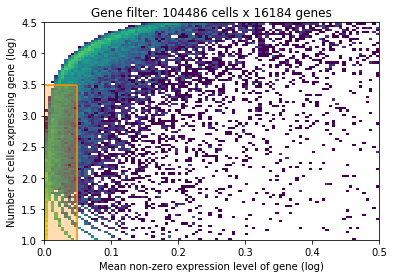

In [11]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [12]:
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='dataset',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_specific_final',
#                         # multiplicative technical effects (platform, 3' vs 5', donor effect)
#                         categorical_covariate_keys=['Method']
                       )

In [13]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

In [14]:
# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Epoch 1/250:   0%|                                                                                                                                                                                                          | 0/250 [00:00<?, ?it/s]

/diskmnt/Projects/Users/estorrs/miniconda3/envs/cell2loc/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...

KeyboardInterrupt



In [ ]:
cell2location.models.RegressionModel.view_anndata_setup(

In [20]:
# prepare anndata for the regression model
# model = RegressionModel(adata_ref)
# model.

scvi.model..setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='dataset',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type_specific_final',
#                         # multiplicative technical effects (platform, 3' vs 5', donor effect)
#                         categorical_covariate_keys=['Method']
                       )
# scvi.model.SCVI.view_anndata_setup()

ValueError: Please set up your AnnData with RegressionModel.setup_anndata first. It appears the AnnData object has been setup with a different model.

In [19]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=False)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

ValueError: Please set up your AnnData with RegressionModel.setup_anndata first. It appears the AnnData object has been setup with a different model.

In [10]:
a = sc.read_h5ad('../data/spatial/cell2location/inputs/sc.h5ad')
a

AnnData object with n_obs × n_vars = 73260 × 10237
    obs: 'Age', 'BCELL_CLONE', 'BCELL_CLONE_SIZE', 'Donor', 'ID', 'IGH_MU_FREQ', 'ISOTYPE', 'LibraryID', 'Method', 'Population', 'PrelimCellType', 'Sample', 'Sex', 'Study', 'Tissue', 'barcode', 'batch', 'doublet_score', 'index', 'predicted_doublet', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'VDJsum', 'cell_cycle_diff', 'PrelimCellType_new', 'leiden', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'CellType', 'CellType2', 'Subset', 'Subset_Broad', 'Subset_all', 'new_celltype', 'Subset_int', 'Subset_print'
    var: 'GeneID-2', 'GeneName-2', 'feature_types', 'feature_types-0', 'feature_types-1', 'gene_ids-1', 'gene_ids-4861STDY7135913-0', 'gene_ids-4861STDY7135914-0', 'gene_ids-4861STDY7208412-0', 'gene_ids-4861STDY7208413-0', 'gene_ids-Human_colon_16S7255677-0', 'gene_ids-Human_colon_16S7255678-0', 'gene_ids-Human_colon_16S8000484-0', 'gene_ids-Pan_T7935494-0', 'genome-1', 'n_cells', 'nonz_mean', 'mean_cov_

In [ ]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [9]:
!cd ../data/spatial/cell2location/inputs && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad
    
    
    

--2022-05-10 09:54:03--  https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad
Resolving cell2location.cog.sanger.ac.uk (cell2location.cog.sanger.ac.uk)... 193.62.203.63, 193.62.203.61, 193.62.203.62
Connecting to cell2location.cog.sanger.ac.uk (cell2location.cog.sanger.ac.uk)|193.62.203.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552080848 (527M) [application/x-hdf]
Saving to: ‘sc.h5ad’

100%[======================================>] 552,080,848 22.6MB/s   in 20s    

2022-05-10 09:54:25 (26.6 MB/s) - ‘sc.h5ad’ saved [552080848/552080848]

